In [3]:
import json
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from PIL import Image


In [ ]:
conf_threshold = 0.6
save_csv_file = True
save_plots = False

# Json Daten Megedetectron lesen

In [ ]:
train_features_label = pd.read_csv("../eda/train_features_label.csv", index_col='id')

mega_json = json.load(open('train_features_output.json'))
mega_json.keys()

In [ ]:
dict_detection_cat = mega_json['detection_categories']
dict_detection_cat

In [ ]:
mega_detector_info = mega_json['info']
mega_detector_info

In [ ]:
df_images = pd.DataFrame(mega_json["images"])
df_images = df_images.reset_index(drop=True)
df_images

In [ ]:
# several bbox per image possible
df_images['detections'][0]

# Daten in geeignetes Format bringen

In [ ]:
def read_megadetector_json(path_json:str = 'train_features_output.json'):
    mega_json = json.load(open(path_json))

    df_images = pd.DataFrame(mega_json["images"])
    df_images = df_images.reset_index(drop=True)
    return df_images


def crop_image_to_normalized_bbox(image_path, normalized_bbox):
    # Laden Sie das Bild mit PIL und konvertieren Sie es in ein PyTorch-Tensor
    image = Image.open(image_path)
    image_width, image_height = image.size
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image)
    # Umrechnen der normalisierten Bounding-Box-Koordinaten in Pixelkoordinaten
    x, y, width, height = normalized_bbox
    remove_bbox_xy = 4
    remove_bbox_wh = remove_bbox_xy * 2
    x = int(np.round(x * image_width, 0)) + remove_bbox_xy
    y = int(np.round(y * image_height, 0)) + remove_bbox_xy
    width = int(np.round(width * image_width, 0)) - remove_bbox_wh
    height = int(np.round(height * image_height, 0)) - remove_bbox_wh
    # Schneiden Sie das Bild auf die Bounding-Box zu
    cropped_image_tensor = image_tensor[:, y:y+height, x:x+width]
    # Konvertieren Sie das zugeschnittene Tensor zurück in ein PIL-Bild
    to_pil = transforms.ToPILImage()
    cropped_image = to_pil(cropped_image_tensor)
    return cropped_image
# Pfad zum Bild, das zugeschnitten werden soll
image_path = "../megadetector/train_features_detection_th01/zj000000_detections.jpg"
# Normalisierte Bounding-Box-Koordinaten (x, y, Breite, Höhe)
normalized_bbox = (0.1093, 0.5888, 0.0802, 0.1851)
# Schneiden Sie das Bild auf die Bounding-Box zu und speichern Sie das Ergebnis
cropped_image = crop_image_to_normalized_bbox(image_path, normalized_bbox)
#cropped_image.save("cropped_normalized_image.jpg")
display(cropped_image)


def get_clean_dataframe_from_json(threshold:float=0.6, save_csv=False, filter_th=True):
    '''
    filter: filters bbox below threshold if true
    '''

    df_images = read_megadetector_json()

    df_images_detections = df_images['detections'].apply(pd.Series, dtype='object')
    #display(df_images_detections.head(2))

    df_images_clean = df_images.merge(df_images_detections, left_index=True, right_index=True).drop(columns='detections')
    #display(df_images_clean.head(2))

    df_images_clean = df_images_clean.melt(id_vars=['file', 'max_detection_conf']).sort_values('file')
    #display(df_images_clean)

    # remove nan values 
    df_images_clean = df_images_clean.dropna(subset='value')
    df_images_clean = df_images_clean.drop(columns='variable')

    # expand category, conf, bbox
    df_cat_conf_bbox = df_images_clean['value'].apply(pd.Series, dtype='object')
    df_images_clean = df_images_clean.merge(df_cat_conf_bbox, left_index=True, right_index=True).drop(columns='value')

    # take only detections for max detection conf
    df_images_clean = df_images_clean[df_images_clean['max_detection_conf'] == df_images_clean['conf']]
    df_images_clean = df_images_clean.reset_index(drop=True)

    # leftjoin clean data
    df_images_clean = pd.merge(df_images['file'], df_images_clean, on='file', how='left')

    # cast datatypes
    df_images_clean['category'] = df_images_clean['category'].astype('category')
    df_images_clean['category'] = df_images_clean['category'].replace(dict_detection_cat)

    # change index to image name
    df_images_clean['image_name'] = [image.replace('.jpg', '') for image in df_images_clean['file']]
    df_images_clean.index = df_images_clean['image_name']
    df_images_clean = df_images_clean.drop(columns='image_name')

    if filter_th: 
        df_images_clean = df_images_clean[df_images_clean['max_detection_conf'] > threshold]
        
    if save_csv: df_images_clean.to_csv(f'megadetector_image_detection_bbox_th{str(threshold).replace(".", "")}.csv')

    return df_images_clean




In [ ]:
# Check the quality of the bounding boxes for all confidence levels with filter_th=False.
df_images_clean = get_clean_dataframe_from_json(0, save_csv=False, filter_th=False)
df_images_clean

Todo: Unterschiedliche Shapes zwischen `df_images` und `df_images_clean` -> `16488` und `16491` ?

In [ ]:
df_images[~df_images['file'].isin(df_images_clean['file'])]


In [ ]:
df_images_clean[~df_images_clean['file'].isin(df_images['file'])]

# Untersuche Kategorien  
Das Modell des Megadetectors unterscheidet zwischen drei Kategorien: `Animal`, `Person`, `Vehicle`

In [ ]:
df_images_clean['category'].unique().to_list()

In [ ]:
figsize = (8, 4)

figure = plt.figure(figsize=figsize)
df_images_clean['category'].value_counts().plot.bar()
cat_na = df_images_clean.shape[0]- df_images_clean['category'].value_counts().sum()
plt.title(f'Verteilung der detektierten Kategorien, na:{cat_na}')
plt.ylabel('Count')
plt.tight_layout()
if save_plots: plt.savefig('./plots/dist_detection_classes.png')
plt.show()

In [ ]:
figure = plt.figure(figsize=figsize)
df_images_clean[df_images_clean['category'] == 'animal']['max_detection_conf'].plot.hist()
plt.title('Verteilung von max_detection_conf für Kategorie 1 (Animal)')
plt.xlabel('max_detection_conf')
plt.tight_layout()
if save_plots: plt.savefig('./plots/dist_conf_animal.png')
plt.show()

In [ ]:
figure = plt.figure(figsize=figsize)
df_images_clean[df_images_clean['category'] == 'person']['max_detection_conf'].plot.hist()
plt.title('Verteilung von max_detection_conf für Kategorie 2 (Person)')
plt.xlabel('max_detection_conf')
plt.tight_layout()
if save_plots: plt.savefig('./plots/dist_conf_person.png')
plt.show()

In [ ]:
figure = plt.figure(figsize=figsize)
df_images_clean[df_images_clean['category'] == 'vehicle']['max_detection_conf'].plot.hist()
plt.title('Verteilung von max_detection_conf für Kategorie 3 (vehicle)')
plt.xlabel('max_detection_conf')
plt.tight_layout()
if save_plots: plt.savefig('./plots/dist_conf_vehicle.png')
plt.show()

## Prüfe einzelne Bilder für die Klassen `person` und `vehicle`
*Bilder aus den Megadetector Vorhersagen*

In [ ]:
lst_img_cat1 = df_images_clean[df_images_clean['category'] == 'animal']['file']
lst_img_cat1 = lst_img_cat1.reset_index(drop=True)
lst_img_cat1 = [image_name.replace('.jpg', '') for image_name in lst_img_cat1]
lst_img_cat1

lst_img_cat2 = df_images_clean[df_images_clean['category'] == 'person']['file']
lst_img_cat2 = lst_img_cat2.reset_index(drop=True)
lst_img_cat2 = [image_name.replace('.jpg', '') for image_name in lst_img_cat2]
lst_img_cat2

lst_img_cat3 = df_images_clean[df_images_clean['category'] == 'vehicle']['file']
lst_img_cat3 = lst_img_cat3.reset_index(drop=True)
lst_img_cat3 = [image_name.replace('.jpg', '') for image_name in lst_img_cat3]
lst_img_cat3

path_img_train = '../competition_data/'
path_img_mega = './train_features_detection_th01/'

Random Ansicht `person`

In [ ]:
random_lst_img_cat2 = random.sample(lst_img_cat2, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# iterate through each bad image
for idx, (img_id, ax) in enumerate(zip(random_lst_img_cat2, axes.flat)):
    # get image label
    img_label = train_features_label.loc[img_id]['label']
    # reads the filepath and returns a numpy array
    img = mpimg.imread(path_img_mega + str(img_id).upper() + '_detections.jpg')
    # get category
    cat, conf = df_images_clean.loc[img_id]['category'], df_images_clean.loc[img_id]['max_detection_conf'], 
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {img_label} | {cat} | Conf: {conf:2f}", fontsize=8)

plt.tight_layout()
plt.show() 

Random Ansicht `vehicle`

In [ ]:
random_lst_img_cat3 = random.sample(lst_img_cat3, 6) 

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# iterate through each bad image
for idx, (img_id, ax) in enumerate(zip(random_lst_img_cat3, axes.flat)):
    # get image label
    img_label = train_features_label.loc[img_id]['label']
    # reads the filepath and returns a numpy array
    img = mpimg.imread(path_img_mega + str(img_id).upper() + '_detections.jpg')
    # get category
    cat, conf = df_images_clean.loc[img_id]['category'], df_images_clean.loc[img_id]['max_detection_conf'], 
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {img_label} | {cat} | Conf: {conf:2f}", fontsize=8)

plt.tight_layout()
plt.show()


## Random Ansicht `animal`

In [ ]:
random_lst_img_cat1 = random.sample(lst_img_cat1, 12)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# iterate through each bad image
for idx, (img_id, ax) in enumerate(zip(random_lst_img_cat1, axes.flat)):
    # get image label
    img_label = train_features_label.loc[img_id]['label']
    # reads the filepath and returns a numpy array
    img = mpimg.imread(path_img_mega + str(img_id).upper() + '_detections.jpg')
    # get category
    cat, conf = df_images_clean.loc[img_id]['category'], df_images_clean.loc[img_id]['max_detection_conf'], 
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {img_label} | {cat} | Conf: {conf:2f}", fontsize=8)

fig.tight_layout()
plt.show()

## Beispiele für Falschklassifikation mit hoher Confidence

In [ ]:
missclassification_findings = ['ZJ010981', 'ZJ014854', 'ZJ003542']
random_miss_class= random.sample(missclassification_findings, 3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))

# iterate through each bad image
for idx, (img_id, ax) in enumerate(zip(random_miss_class, axes.flat)):
    # get image label
    img_label = train_features_label.loc[img_id]['label']
    # reads the filepath and returns a numpy array
    img = mpimg.imread(path_img_mega + str(img_id).upper() + '_detections.jpg')
    # get category
    cat, conf = df_images_clean.loc[img_id]['category'], df_images_clean.loc[img_id]['max_detection_conf'], 
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {img_label} | {cat} | Conf: {conf:2f}", fontsize=8)

plt.tight_layout()
plt.show()

## Merge Bbox und Bildlabel

In [ ]:
def get_df_bbox_label(label_path:str="../eda/train_features_label.csv", threshold_bbox:float=0.4, filter_th=True):
    '''
    label_path: path for images and label csv
    threshold_bbox: set confidence threshold
    The function cleans the Megadetector JSON file, removes the bounding boxes for
    confidence levels lower than the specified threshold. Creates a dataframe with
    Image name, labels and bounding boxes
    '''
    train_features_label = pd.read_csv(label_path, index_col='id')

    df_images_th = get_clean_dataframe_from_json(threshold_bbox, save_csv=False, filter_th=filter_th)
    df_images_th_label = train_features_label.merge(df_images_th, left_index=True, right_index=True, how='left')
    df_images_th_label['bbox_true'] = df_images_th_label['bbox'].notnull()

    return df_images_th_label

In [ ]:
threshold = 0.4
df_images_th04_label = get_df_bbox_label(threshold_bbox=threshold, filter_th=True)
df_images_th04_label

## Prüfe verschiedene Thresholds für Megadetector Confidence
Es ist schwierig die Qualität der Bounding Boxen quantitativ zu prüfen. Folgend wird getestet, ob für für die einzelnen Tierklassen eine Boundingbox zu verschiedenen Threshold vorhanden ist.

In [ ]:
def count_bbox_th_class(animal_class, thresholds:list):
    '''
    animal_class: class
    thresholds: list with thresholds to be tested
    Function filters df for class and counts the relative number [%]
    of bbox available (bbox either false or true)
    '''
    bbox_true_list = []
    bbox_fals_list = []
    for th in thresholds:
        df_images_th_label = get_df_bbox_label(threshold_bbox=th)

        df_images_class = df_images_th_label[df_images_th_label['label'] == animal_class]
        relative_count = (df_images_class['bbox_true']
                            .value_counts(normalize=True)
                            .sort_values(ascending=False)
                            .sort_index(ascending=False))

        bbox_true_list.append(relative_count[0]*100)
        bbox_fals_list.append(relative_count[1]*100)

    return bbox_true_list, bbox_fals_list

def plot_count_bbox_th_class(animal_class, thresholds, figsize=(6,4), save_plot=False):
    blank_bbox_true, blank_bbox_false = count_bbox_th_class(animal_class, thresholds)

    figure = plt.figure(figsize=figsize)
    plt.plot(thresholds, blank_bbox_true)
    plt.suptitle('Relativer Count für Bbox zu verschiedenen Treshholds', fontsize=12)
    plt.title(f'Klasse {animal_class}', fontsize=10)
    plt.xlabel('thresholds', fontsize=8)
    plt.ylabel('relativer Anteil [%]', fontsize=10)
    plt.axvspan(thresholds[0], 0.4, facecolor='gray', alpha=0.2)
    plt.axvspan(0.7, thresholds[-1], facecolor='gray', alpha=0.2)
    plt.grid()
    plt.tight_layout()
    if save_plots: plt.savefig(f'./plots/rel_count_bbox_{animal_class}.png')
    plt.show()

def plot_count_bbox_th_class_all(thresholds, figsize=(12,6), save_plot=False): 
    classes = ['bird', 'monkey_prosimian', 'leopard', 'hog', 'civet_genet',
            'antelope_duiker', 'blank', 'rodent']
    
    figure = plt.figure(figsize=figsize)    
    for animal_class in classes:
        class_bbox_true, class_bbox_false = count_bbox_th_class(animal_class, thresholds)
    
        plt.plot(thresholds, class_bbox_true, label=f'{animal_class}')
    
    plt.suptitle('Relativer Count für Bbox zu verschiedenen Treshholds', fontsize=12)
    plt.xlabel('thresholds', fontsize=8)
    plt.ylabel('relativer Anteil [%]', fontsize=10)
    plt.legend(loc='upper right', bbox_to_anchor=(1.21, 1))
    plt.axvspan(thresholds[0], 0.4, facecolor='gray', alpha=0.5)
    plt.axvspan(0.7, thresholds[-1], facecolor='gray', alpha=0.2)
    plt.grid()
    plt.tight_layout()
    if save_plots: plt.savefig(f'./plots/rel_count_bbox_all_classes.png')
    plt.show()

In [ ]:
# test plots
df_images_th_label = get_df_bbox_label(threshold_bbox=0.7)

df_images_class = df_images_th_label[df_images_th_label['label'] == 'blank']
df_images_class['bbox_true'].value_counts(normalize=True).sort_values(ascending=False).sort_index(ascending=False)

### Prüfe Klasse `blank`

In [ ]:
#thresholds = [0.4, 0.5, 0.6, 0.7]
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [ ]:
# runtime: ca. 2min
plot_count_bbox_th_class('blank', thresholds, save_plot=save_plots)

Der Megadetector erkennt die `blank` Bilder sehr gut. Mit einem Threshold von `0.7` werden nur zu 0.6% Bounding Boxen vorhergesagt, somit werden zu 99.3% keine Tier auf der Klasse `blank` erkannt.

### Prüfe `alle` Klassen

In [ ]:
# runtime: ca. 12min
# plot_count_bbox_th_class_all(thresholds, save_plot=save_plots)

Das erkennen der einzelnen Tierklassen ist oben abgebildet. Wie zu erwarten sinken die Anzahl Bounding Boxen mit steigendem Threshold. Ein guter Threshold scheint sich zwischen `0.4` und `0.7` zu finden. 
Folgend werden csv Files zu unterschiedlichen Konfidenz-Thresholds gespeichert, somit kann ein optimaler Wert auch durch Modelltests gefunden werden.

## Speichere CSV File
speichere Megadetector Bbox und Tierlabel als csv datei für verschiedene Thresholds

In [ ]:
if save_csv_file:
    df_images_label_all_bbox = get_df_bbox_label(threshold_bbox=0.4, filter_th=False)
    df_images_label_all_bbox.reset_index(drop=False).to_csv(f'megadetector_image_detection_all_bbox.csv', index=False)

    # thresholds_save_csv = [0.4, 0.5, 0.6, 0.7, 0.8]
    # for th in thresholds_save_csv:
    #     df_images_th_label = get_df_bbox_label(threshold_bbox=th)
    #     df_images_th_label.to_csv(f'./bbox_csv/image_label_bbox_th{str(th).replace(".", "")}.csv')


## Bilder auf Bounding boxen zuschneiden

In [123]:
def get_correct_box(image, normalized_bbox):
    image_width, image_height = image.size
    
    x, y, width, height = normalized_bbox
    remove_bbox_xy = 4
    remove_bbox_wh = remove_bbox_xy * 2

    x = int(np.round(x * image_width, 0)) + remove_bbox_xy
    y = int(np.round(y * image_height, 0)) + remove_bbox_xy
    width = int(np.round(width * image_width, 0)) - remove_bbox_wh
    height = int(np.round(height * image_height, 0)) - remove_bbox_wh
    return y,x,height,width

In [134]:
def crop_image_to_normalized_bbox(image, normalized_bbox):
    y,x,height,width = (43, 4, 470, 256) # get_correct_box(image, normalized_bbox)
    image_tensor = transforms.ToTensor()(image)
    return transforms.ToPILImage()((transforms.functional.crop(image_tensor,y,x,height,width)))

In [140]:
df = pd.read_csv("megadetector_image_detection_all_bbox.csv")
df = df[df["id"].duplicated()==False].reset_index()
bbox_transformed = []
for id in range(len(df)):
    if df.iloc[id]["bbox_true"]:
        path = r"../competition_data/" + df.iloc[id]["filepath"]
        image = Image.open(path).convert("RGB")
        normalized_bbox = ast.literal_eval(df.iloc[id]['bbox'])
        bbox_transformed.append(get_correct_box(image, normalized_bbox))
    else:
        bbox_transformed.append(pd.NA)

In [141]:
df["bbox_transformed"] = pd.Series(bbox_transformed)

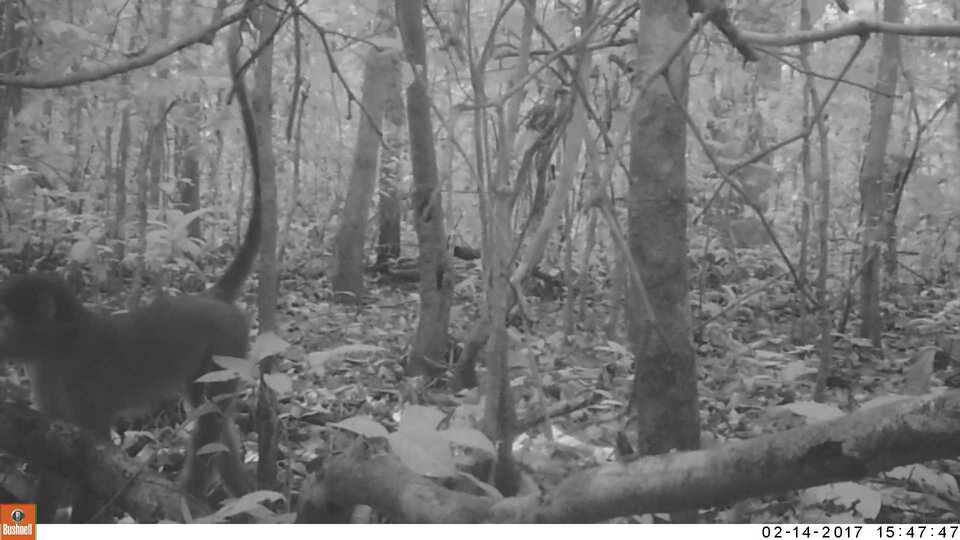

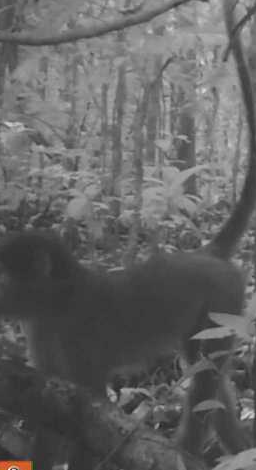

In [135]:
df = pd.read_csv("megadetector_image_detection_all_bbox.csv")
df = df[df["id"].duplicated()==False]
#df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x))

id= 16102

path = r"../competition_data/" + df.iloc[id]["filepath"]
image = Image.open(path).convert("RGB")


data_path = "../megadetector/train_features_detection_th01/"
image_path = f'{data_path}{df["id"][id]}'

normalized_bbox = ast.literal_eval(df.iloc[id]['bbox'])
cropped_image = crop_image_to_normalized_bbox(image, normalized_bbox)

display(image)
display(cropped_image)